In [50]:
!pip install gymnasium
!pip install pybullet
!pip install robot_descriptions

In [51]:
import cv2
import numpy as np
import plotly.express as px
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as anm

Define the linearized dynamics of the system:

In [52]:
g = 9.8     #acceleration due to earth's gravity
lp = 0.5    #length of pole
mp = 0.1    #mass of pole
mk = 1      #mass of cart
mt = mp+mk

In [53]:
# state matrix
a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

Second, lets calculate the optimal controller:

In [54]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
Q = 50*np.eye(4, dtype=int)        # choose Q (weight for state)


#R = 5*np.array([[1]])

Q = 50*np.array([[100, 0, 0, 0],
                [0, 100, 0, 0],
                [0, 0, 10, 0],
                [0, 0, 0, 100]])

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

And last, lets define a function, which we can call to actually calculate the input force F during runtime:

In [55]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

Now we can set up the simulation!

In [56]:
# get environment
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.observation_space.seed(1)     # seed for reproducibility
obs, _ = env.reset()
obs_ = [obs.tolist()]

out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (600, 400))

for i in range(1000):
    img = env.render()
    out.write(img)

    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)

    # change magnitute of the applied force in CartPole
    abs_force = abs(float(np.clip(force, -10, 10)))
    env.force_mag = abs_force
    #print(force)

    # apply action
    obs, reward, done, _, _ = env.step(action)
    obs_.append(obs.tolist())


    if done:
        print(f'Terminated after {i+1} iterations.')
        break

out.release()
env.close()

Plot the state variables

In [57]:
name = ['Position', 'Velocity', 'Vertical Angle', 'Angular Velocity']
fig = px.line()
for i in range(4):
  fig.add_scatter(x = np.linspace(1, len(obs_)+2, len(obs_)+1, dtype=np.int32), y = np.transpose(obs_)[i], name=name[i])
fig.show()


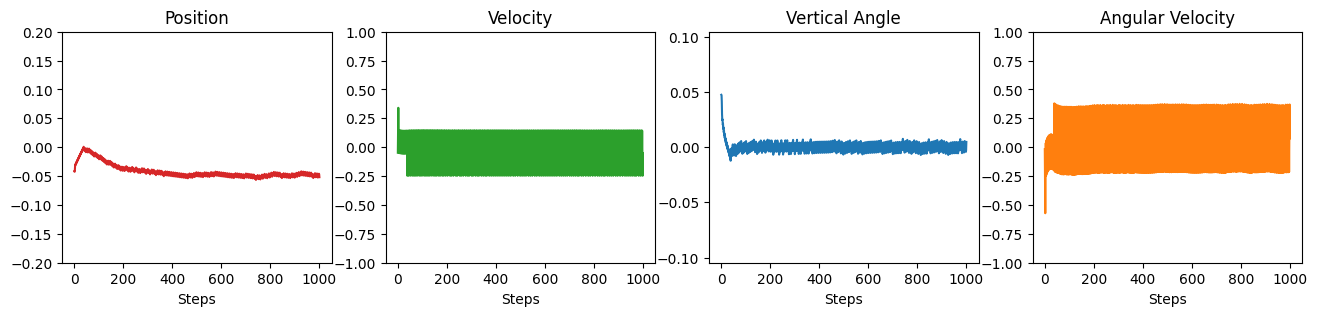

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16,3))

colours = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']

for i in range(4):
  axs[i].plot(np.transpose(obs_)[i], colours[i])
  axs[i].set_title(name[i])

axs[0].set_ylim([-0.2, 0.2])
axs[2].set_ylim([-np.pi/30, np.pi/30])
axs[1].set_ylim([-1., 1.])
axs[3].set_ylim([-1., 1.])

for ax in axs.flat:
  ax.set(xlabel='Steps')

fig.savefig('LQR_plot.png')